https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

In [27]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage

In [4]:
# Step 3: Extract the ZIP File
zip_file_path = 'estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip'
extract_dir = 'obesity_dataset'
os.makedirs(extract_dir, exist_ok=True)


In [5]:

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to '{extract_dir}' directory.")

# Step 4: Inspect Extracted Files
extracted_files = os.listdir(extract_dir)
print("Extracted Files:")
for file in extracted_files:
    print(file)


Files extracted to 'obesity_dataset' directory.
Extracted Files:
ObesityDataSet_raw_and_data_sinthetic.csv


In [28]:
# Step 5: Load the Dataset into a Pandas DataFrame
csv_file_path = os.path.join(extract_dir, 'ObesityDataSet_raw_and_data_sinthetic.csv')
df = pd.read_csv(csv_file_path)
print(df.head())



   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

In [29]:
# Step 6a: Data Overview
print(df.info())
print(df.describe(include='all'))
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

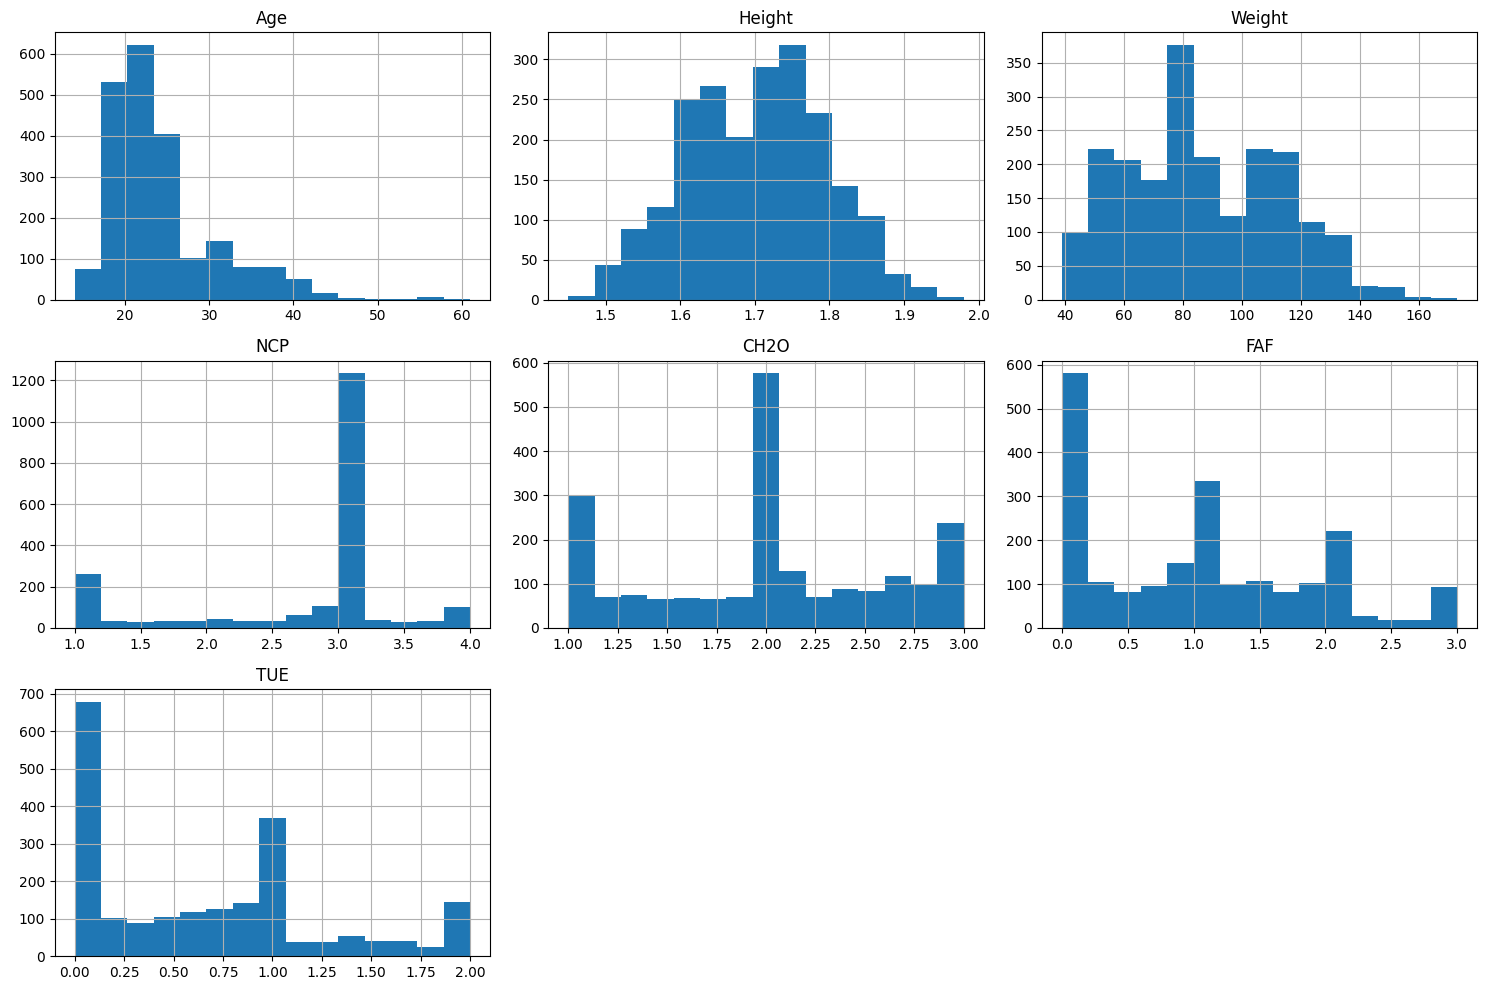

In [7]:
# Step 6b: Visualize Feature Distributions
# Continuous Features
continuous_features = ['Age', 'Height', 'Weight', 'NCP', 'CH2O', 'FAF', 'TUE']
df[continuous_features].hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.tight_layout()
plt.show()

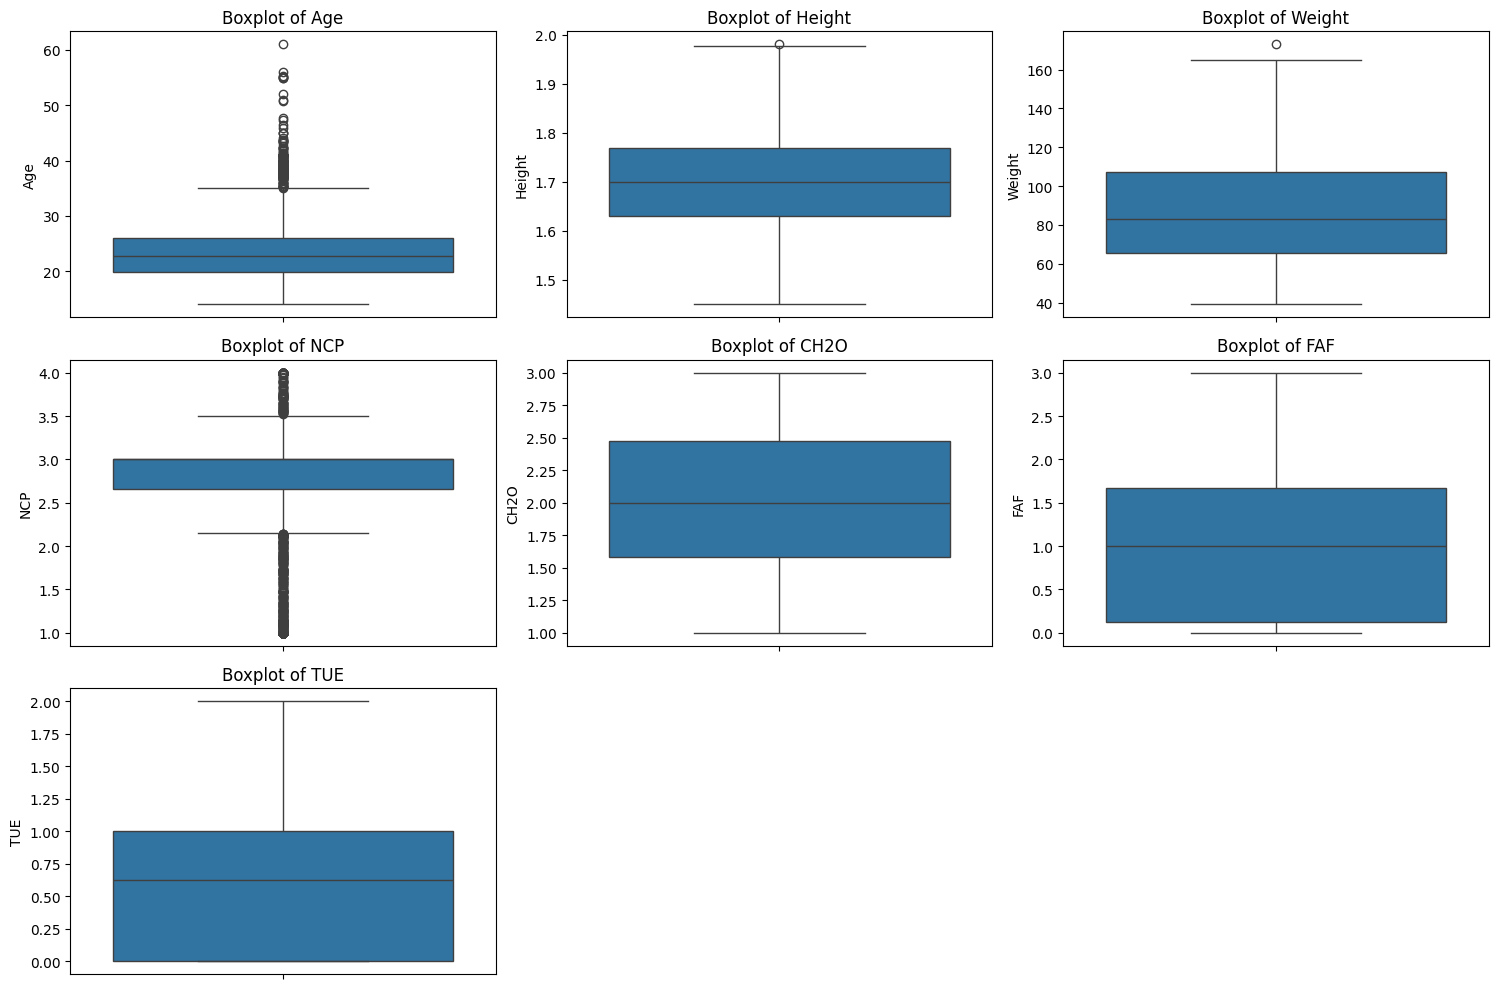

In [8]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

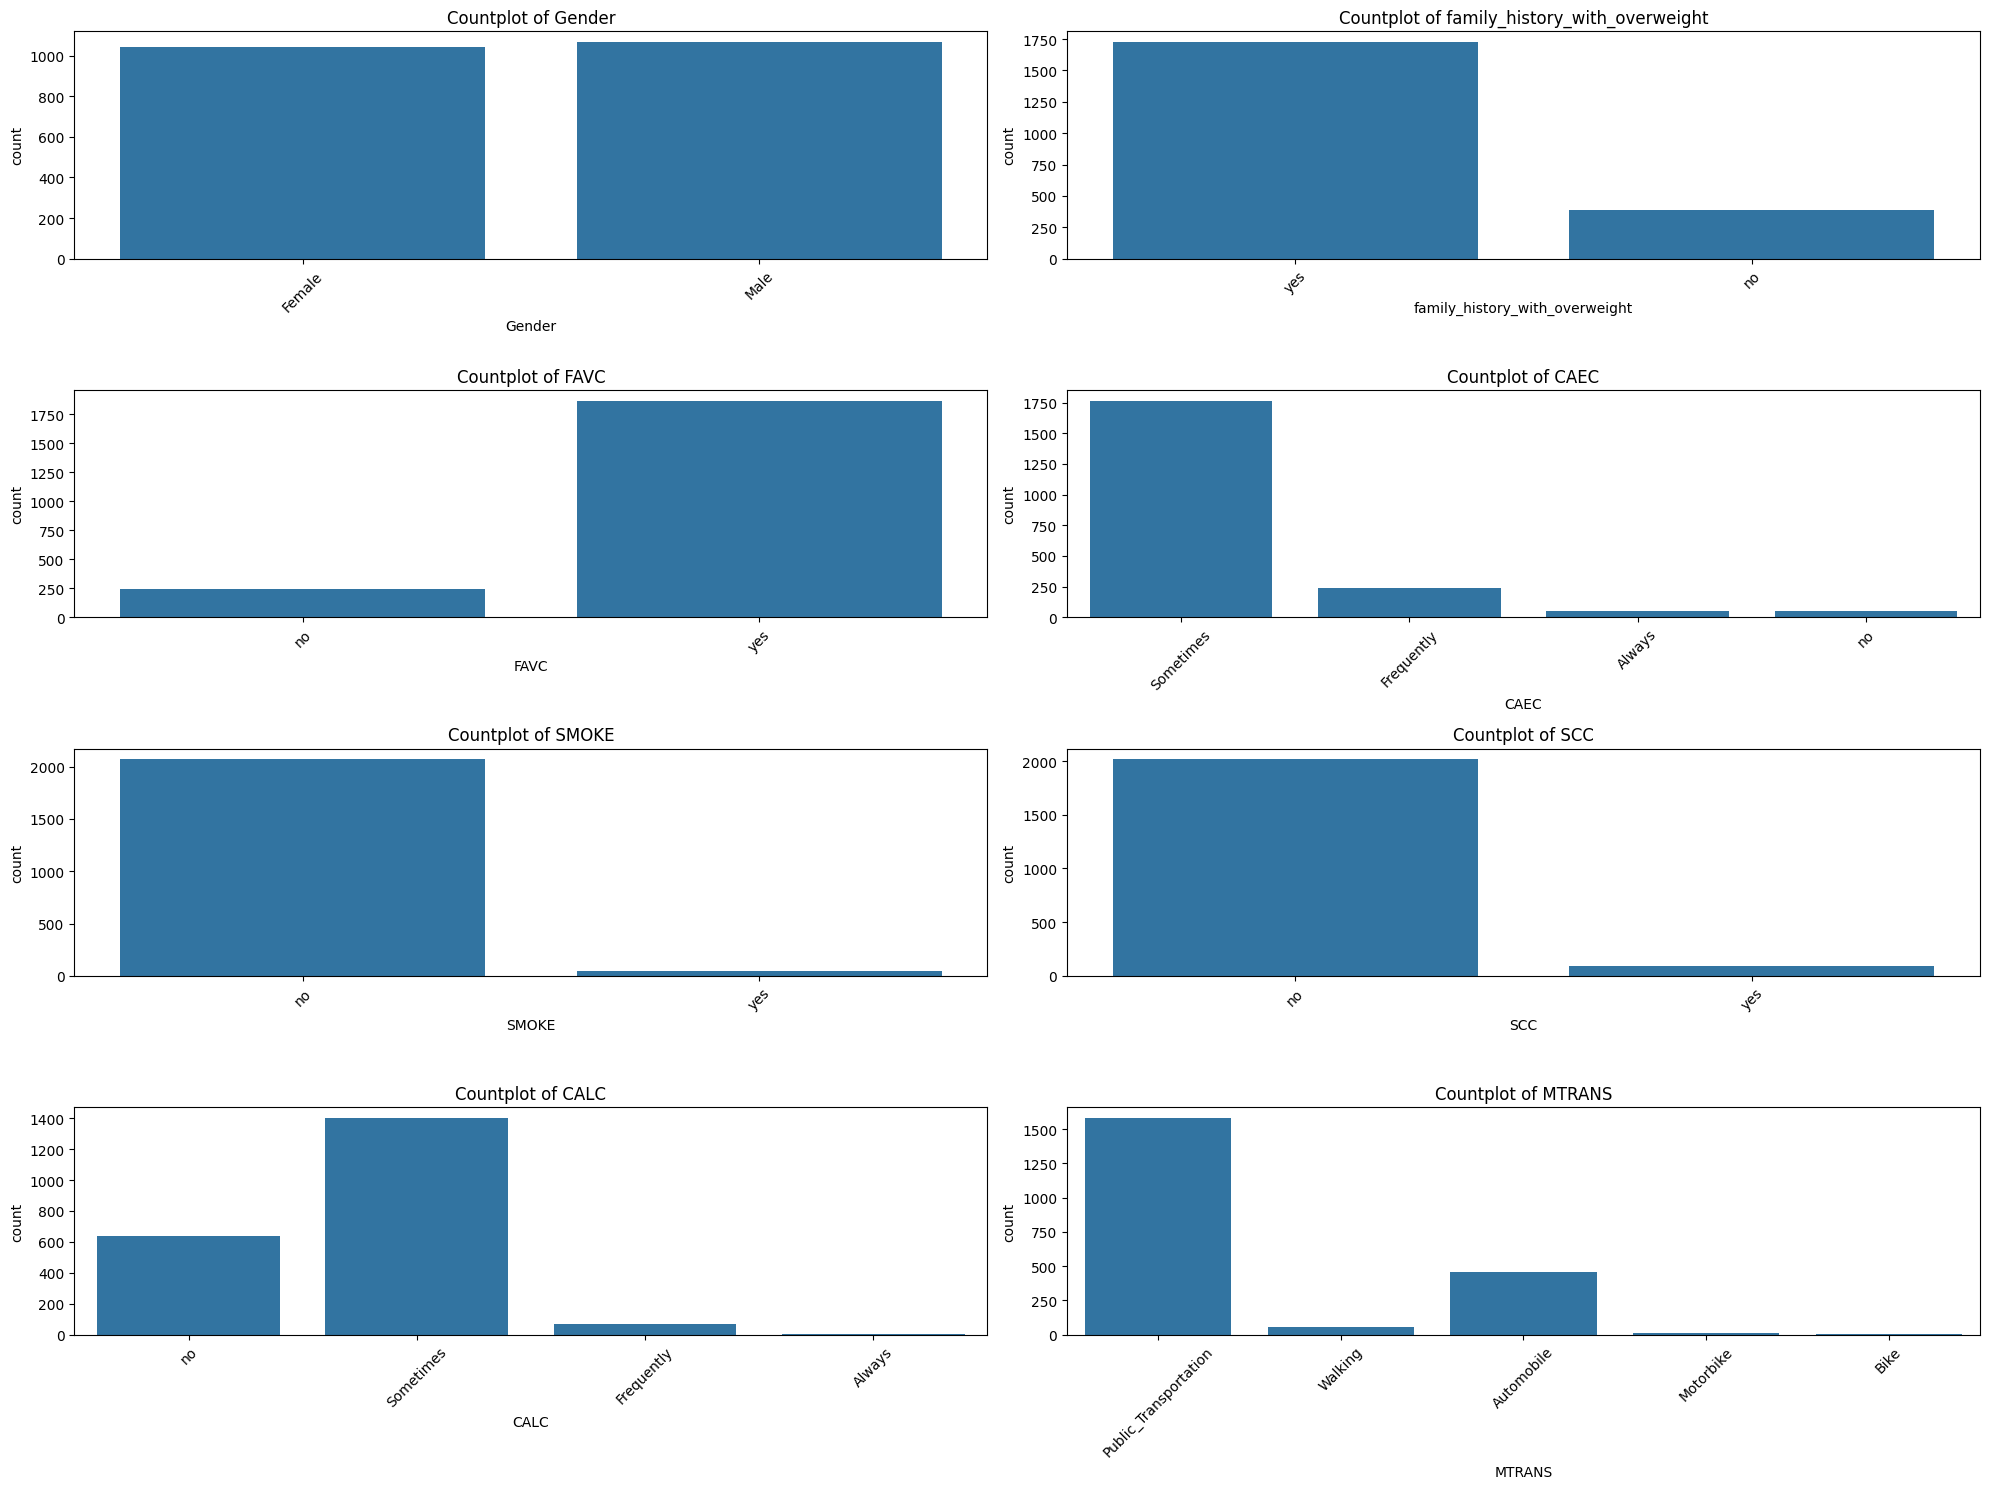

In [9]:
# Categorical Features
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC',
                        'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=df, x=feature)
    plt.title(f'Countplot of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

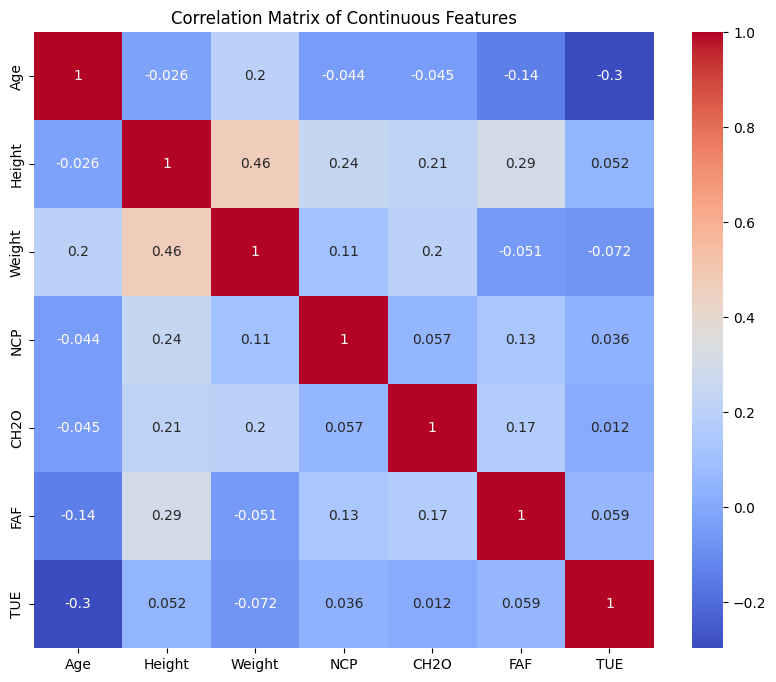

In [10]:

# Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df[continuous_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Continuous Features')
plt.show()

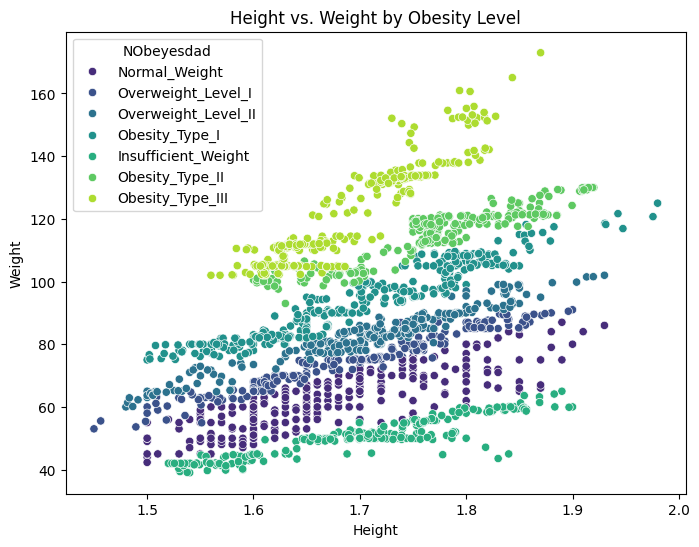

In [11]:
# Relationship Between Features
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Height', y='Weight', hue='NObeyesdad', palette='viridis')
plt.title('Height vs. Weight by Obesity Level')
plt.show()

In [12]:
# Step 7a: Data Preprocessing - Handling Categorical Variables
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

X = column_transformer.fit_transform(df.drop('NObeyesdad', axis=1))
encoder = column_transformer.named_transformers_['encoder']
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
remaining_features = [col for col in df.columns if col not in categorical_features + ['NObeyesdad']]
feature_names = list(encoded_feature_names) + remaining_features
X = pd.DataFrame(X, columns=feature_names)
print(X.head())

   Gender_Male  family_history_with_overweight_yes  FAVC_yes  CAEC_Frequently  \
0          0.0                                 1.0       0.0              0.0   
1          0.0                                 1.0       0.0              0.0   
2          1.0                                 1.0       0.0              0.0   
3          1.0                                 0.0       0.0              0.0   
4          1.0                                 0.0       0.0              0.0   

   CAEC_Sometimes  CAEC_no  SMOKE_yes  SCC_yes  CALC_Frequently  \
0             1.0      0.0        0.0      0.0              0.0   
1             1.0      0.0        1.0      1.0              0.0   
2             1.0      0.0        0.0      0.0              1.0   
3             1.0      0.0        0.0      0.0              1.0   
4             1.0      0.0        0.0      0.0              0.0   

   CALC_Sometimes  ...  MTRANS_Public_Transportation  MTRANS_Walking   Age  \
0             0.0  ...          

In [13]:
# Step 7b: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_names)
print(X_scaled.head())


   Gender_Male  family_history_with_overweight_yes  FAVC_yes  CAEC_Frequently  \
0    -1.011914                            0.472291 -2.759769        -0.359835   
1    -1.011914                            0.472291 -2.759769        -0.359835   
2     0.988227                            0.472291 -2.759769        -0.359835   
3     0.988227                           -2.117337 -2.759769        -0.359835   
4     0.988227                           -2.117337 -2.759769        -0.359835   

   CAEC_Sometimes   CAEC_no  SMOKE_yes   SCC_yes  CALC_Frequently  \
0        0.442757 -0.157344  -0.145900 -0.218272        -0.185194   
1        0.442757 -0.157344   6.853997  4.581439        -0.185194   
2        0.442757 -0.157344  -0.145900 -0.218272         5.399735   
3        0.442757 -0.157344  -0.145900 -0.218272         5.399735   
4        0.442757 -0.157344  -0.145900 -0.218272        -0.185194   

   CALC_Sometimes  ...  MTRANS_Public_Transportation  MTRANS_Walking  \
0       -1.404720  ...    

/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1

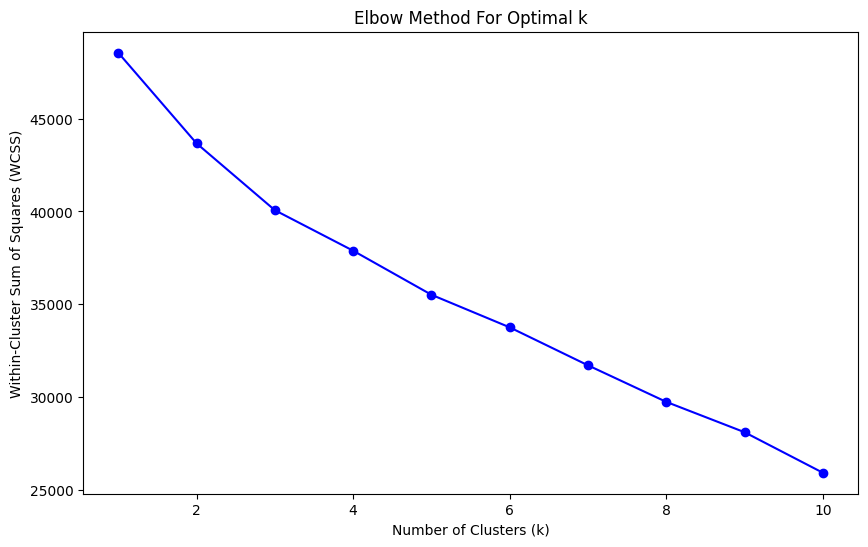

In [14]:
# Step 8a: Model Building - Elbow Method
wcss = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.show()

/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1

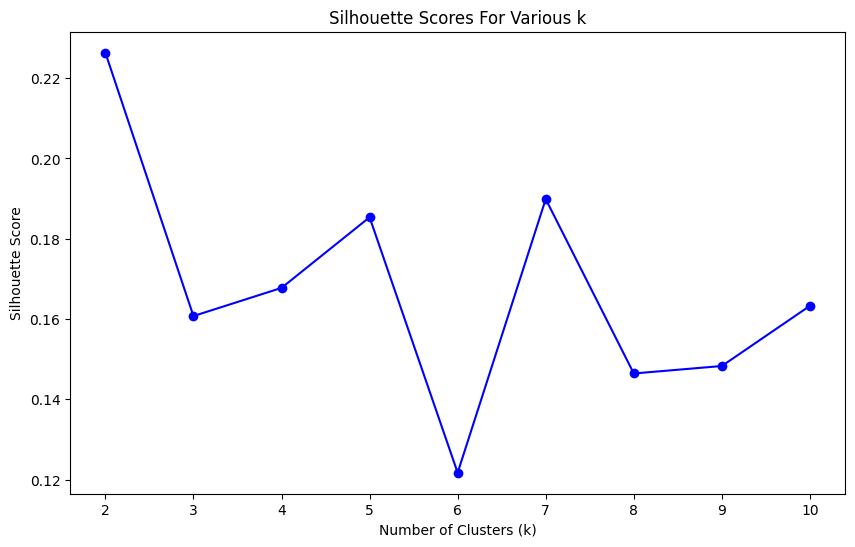

In [15]:
# Step 8b: Silhouette Analysis
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10,6))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Various k')
plt.show()

In [17]:

# Choose optimal_k based on the plots (2)
optimal_k = 2

# Step 8c: Applying K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


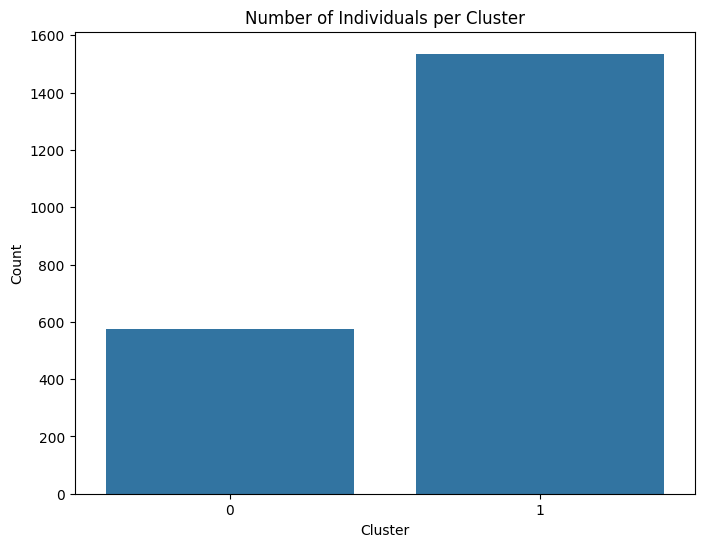

In [18]:
# Step 9a: Cluster Distribution
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Cluster')
plt.title('Number of Individuals per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [19]:
# Step 9b: Visualizing Clusters with PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, df['Cluster']], axis=1)


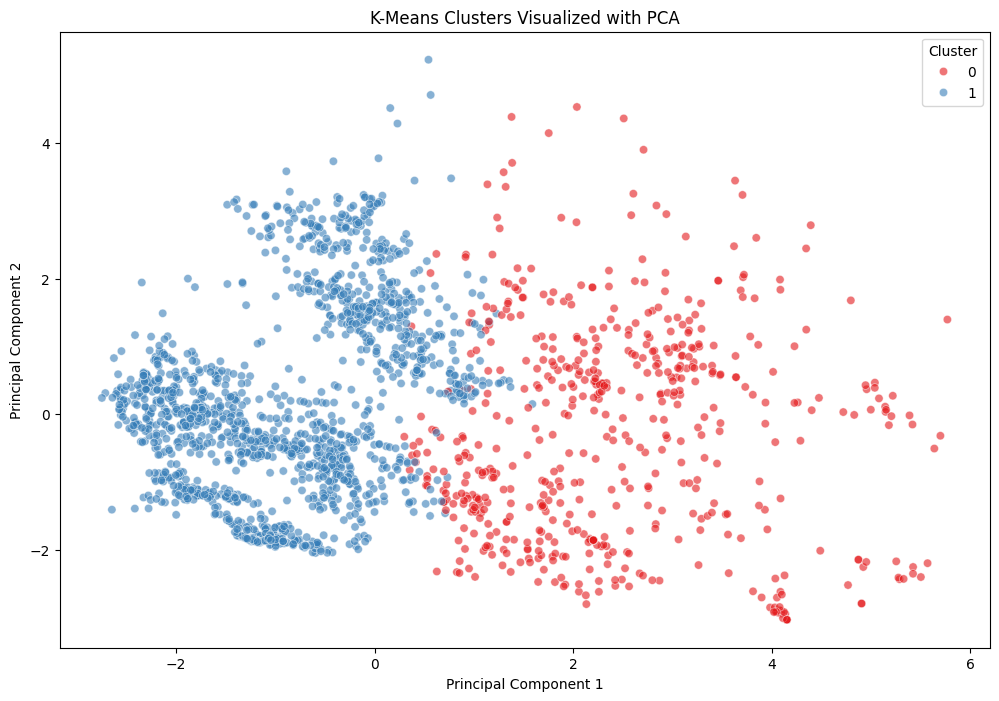

In [20]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.6)
plt.title('K-Means Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [24]:
# Select only numeric columns explicitly before calculating the mean
numeric_columns = df.select_dtypes(include=['number']).columns
cluster_means = df[numeric_columns].groupby(df['Cluster']).mean()

print(cluster_means)


               Age    Height     Weight      FCVC       NCP      CH2O  \
Cluster                                                                 
0        21.487331  1.644783  59.488421  2.380138  2.627109  1.845143   
1        25.370236  1.722976  96.730030  2.433607  2.707535  2.068981   

              FAF       TUE  Cluster  
Cluster                               
0        1.117258  0.699520      0.0  
1        0.970257  0.642273      1.0  


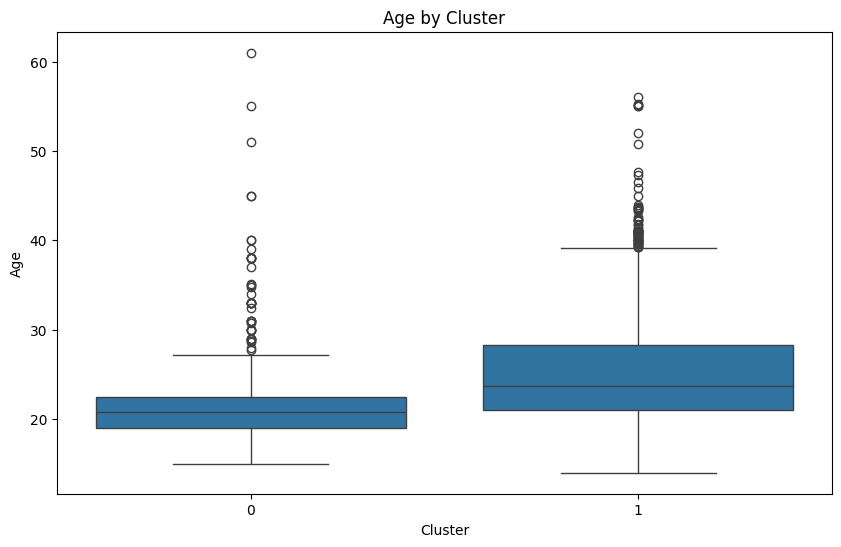

In [25]:

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Cluster', y='Age')
plt.title('Age by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()


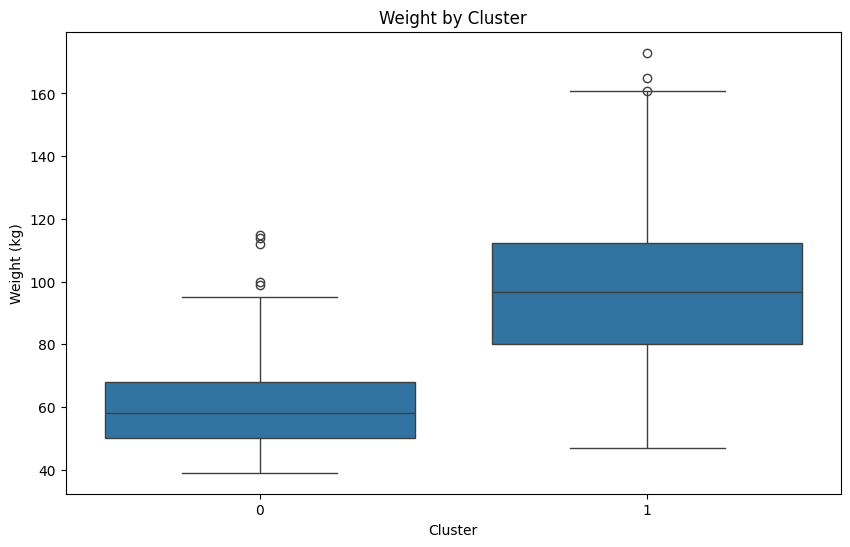

In [26]:

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Cluster', y='Weight')
plt.title('Weight by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Weight (kg)')
plt.show()

In [43]:
# Step 1: Import Libraries
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage

In [44]:
# Step 2: Load and Extract the Dataset
# Replace with the correct path to your ZIP file
zip_file_path = 'estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip'
extract_dir = 'obesity_dataset'
os.makedirs(extract_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Load the CSV file
csv_file_path = os.path.join(extract_dir, 'ObesityDataSet_raw_and_data_sinthetic.csv')
df = pd.read_csv(csv_file_path)


In [45]:
# Step 3: Data Preprocessing
# Select categorical and numerical columns
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 
                        'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [46]:
# One-hot encode categorical features
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

X = column_transformer.fit_transform(df.drop(['NObeyesdad'], axis=1))
encoded_feature_names = column_transformer.named_transformers_['encoder'].get_feature_names_out(categorical_features)
feature_names = list(encoded_feature_names) + numerical_features
X = pd.DataFrame(X, columns=feature_names)

In [47]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [48]:
# Step 4: Train-Test Split for Stability Check
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)


In [49]:
# Step 5: Clustering with KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

In [50]:
# Predict clusters for the entire dataset
full_dataset_clusters = kmeans.predict(X_scaled)


In [51]:
# Predict clusters for test data
test_clusters = kmeans.predict(X_test)

In [52]:
# Cluster evaluation metrics
train_silhouette = silhouette_score(X_train, kmeans.labels_)
test_silhouette = silhouette_score(X_test, test_clusters)
davies_bouldin = davies_bouldin_score(X_train, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(X_train, kmeans.labels_)

In [53]:
print(f"Train Silhouette Score: {train_silhouette:.3f}")
print(f"Test Silhouette Score: {test_silhouette:.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")


Train Silhouette Score: 0.239
Test Silhouette Score: 0.205
Davies-Bouldin Score: 2.667
Calinski-Harabasz Index: 191.093


In [54]:
# Add cluster labels to the dataset
df['Cluster'] = full_dataset_clusters

In [55]:
# Step 6: Visualize Clusters with PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled)

In [56]:
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = full_dataset_clusters  # Predicted clusters for the full dataset

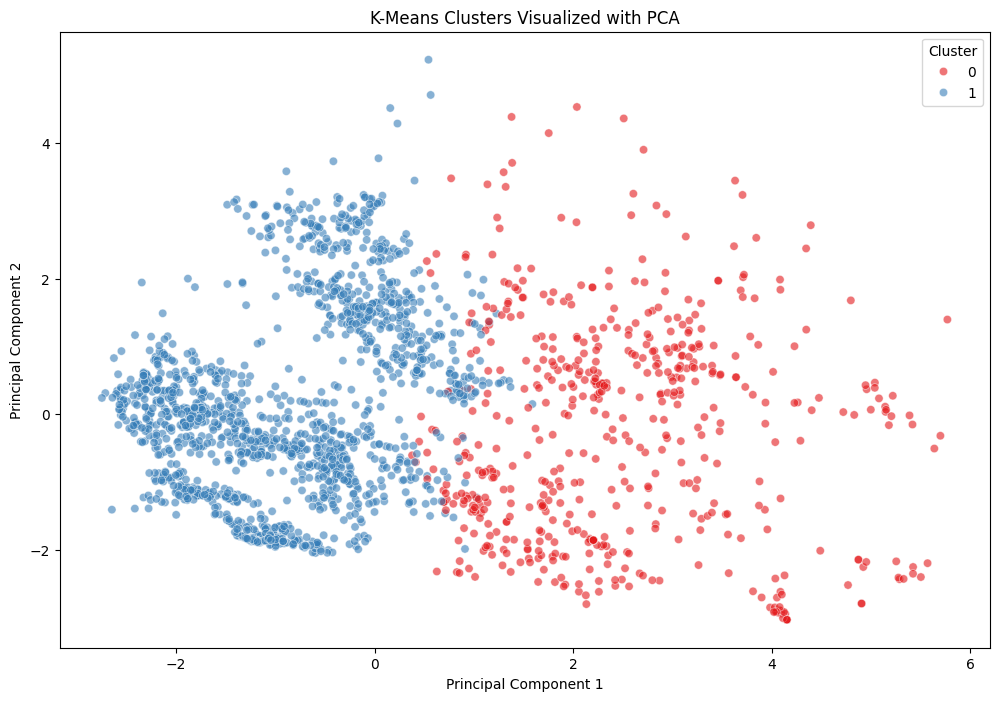

In [57]:
# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.6)
plt.title('K-Means Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

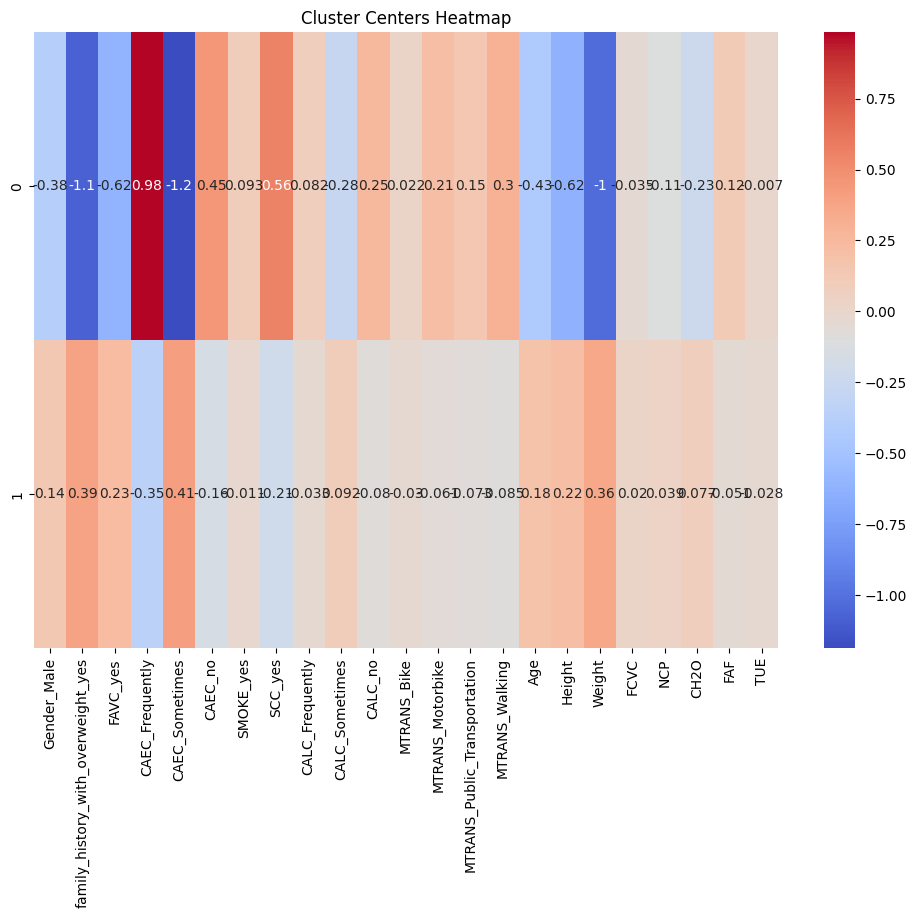

In [58]:
# Step 7: Cluster Centers Heatmap
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=feature_names)
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers, annot=True, cmap='coolwarm')
plt.title('Cluster Centers Heatmap')
plt.show()

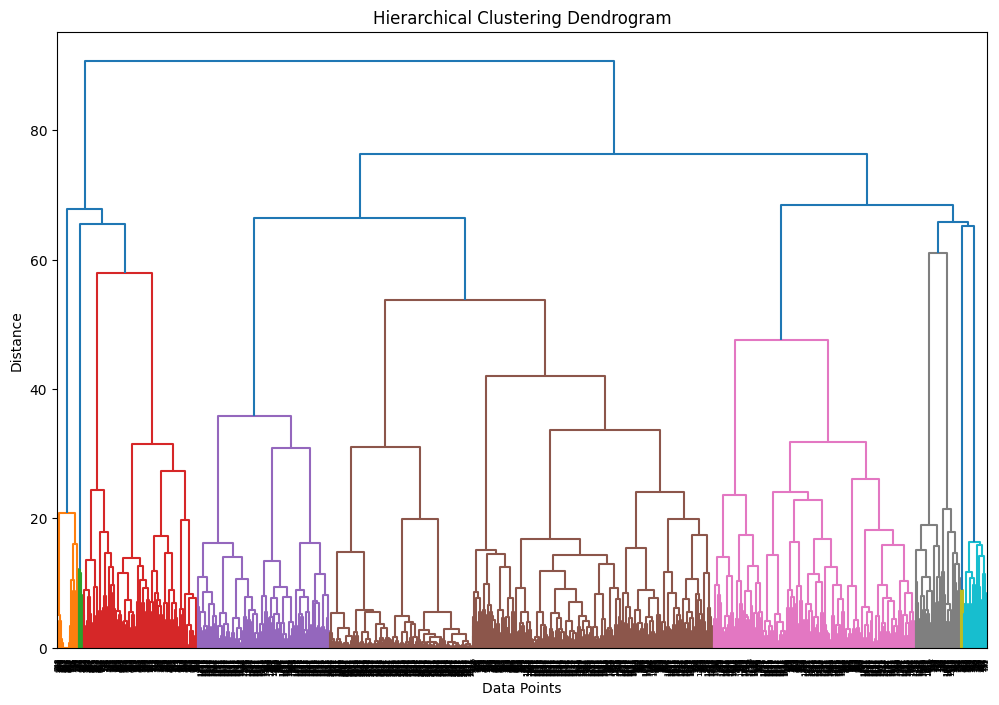

In [59]:
# Step 8: Hierarchical Clustering (Optional)
linkage_matrix = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [60]:
# Step 9: Outlier Detection using DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

In [61]:
# Detect outliers
outliers = X_scaled[dbscan_labels == -1]
print(f"Number of Outliers Detected: {len(outliers)}")

Number of Outliers Detected: 1658


In [62]:
# Step 10: Cluster Interpretation
# Calculate means of numeric features per cluster
numeric_columns = df.select_dtypes(include=['number']).columns
cluster_means = df[numeric_columns].groupby('Cluster').mean()

In [63]:
print("\nCluster Means:")
print(cluster_means)


Cluster Means:
               Age    Height     Weight      FCVC       NCP      CH2O  \
Cluster                                                                 
0        21.528877  1.644999  59.642561  2.387604  2.624515  1.847424   
1        25.320128  1.722191  96.337866  2.430422  2.707747  2.066134   

              FAF       TUE  
Cluster                      
0        1.106343  0.697425  
1        0.975536  0.643548  


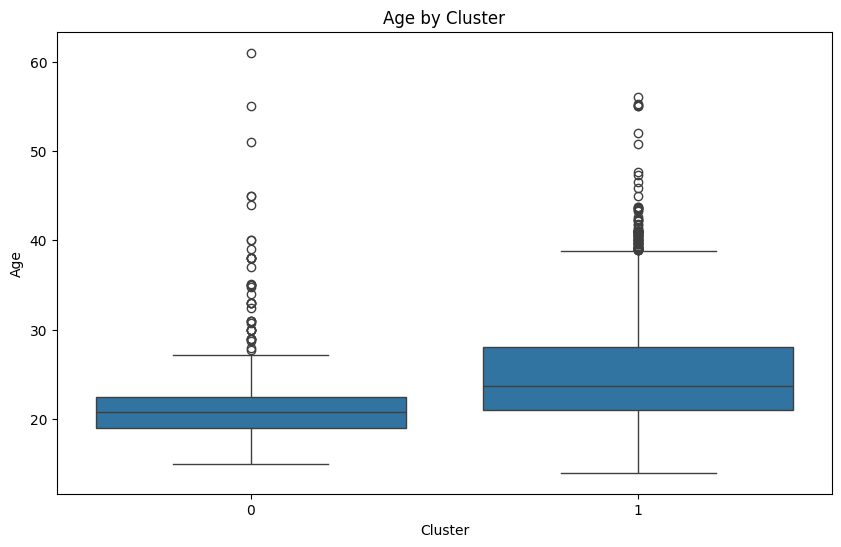

In [64]:
# Step 11: Visualize Cluster Characteristics
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Cluster', y='Age')
plt.title('Age by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

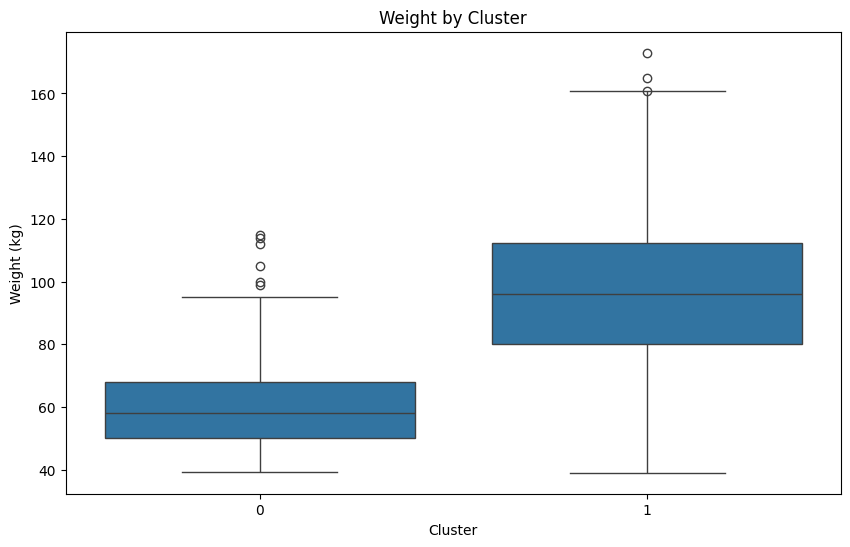

In [65]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Cluster', y='Weight')
plt.title('Weight by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Weight (kg)')
plt.show()

In [66]:
# Step 12: Optional Comparison with Target Variable
if 'NObeyesdad' in df.columns:
    print("\nCross-Tabulation of Clusters and Obesity Levels:")
    print(pd.crosstab(df['Cluster'], df['NObeyesdad']))


Cross-Tabulation of Clusters and Obesity Levels:
NObeyesdad  Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Cluster                                                          
0                           187            207              11   
1                            85             80             340   

NObeyesdad  Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Cluster                                                             
0                         3                 0                  98   
1                       294               324                 192   

NObeyesdad  Overweight_Level_II  
Cluster                          
0                            55  
1                           235  
